In [1]:
using Pkg
Pkg.activate("../")

  Activating project at `~/git/projects/perspective_heart_and_brain`


# EEG data
From https://www.ukbonn.de/epileptologie/arbeitsgruppen/ag-lehnertz-neurophysik/downloads/ 

Reference: Andrzejak RG, Lehnertz K, Rieke C, Mormann F, David P, Elger CE (2001) Indications of nonlinear deterministic and finite dimensional structures in time series of brain electrical activity: Dependence on recording region and brain state,Phys. Rev. E, 64, 061907

Dataset C, sample N062 as suggested in the reference link for patients in seizure free intervals

Dataset E, sample S056 as suggested in the reference link for patient with seizure activity

In [2]:
# selected datasets for the plots stored in dictionary
# notice the mapping A->Z, C->N, E->S
datasets = Dict(
    "example" => "Z093",
    "control" => "N062",
    "seizure" => "S056"
)
links = Dict(
    "Z093" => "https://www.ukbonn.de/site/assets/files/21874/z.zip",
    "N062" => "https://www.ukbonn.de/site/assets/files/21871/n.zip",
    "S056" => "https://www.ukbonn.de/site/assets/files/21875/s.zip"
)
folder = Dict(
    "Z093" => "Z",
    "N062" => "N",
    "S056" => "S"
)
path="./data/Andrzejak_et_al_PhysRevE_2001/"

"./data/Andrzejak_et_al_PhysRevE_2001/"

In [3]:
# download the specific datasets that we work with
# create path
run(`mkdir -p $(path)`)
for (label,dataset) in datasets
    println(dataset)
    # download
    download(links[dataset], path*"tmp.zip")
    # unzip 
    run(`unzip -o $(path*"tmp.zip") "$(folder[dataset]*"/"*dataset*"*")" -d $(path)/`)
    # remove temporary zip file
    run(`rm $(path*"tmp.zip")`)
end

Z093
Archive:  ./data/Andrzejak_et_al_PhysRevE_2001/tmp.zip
  inflating: ./data/Andrzejak_et_al_PhysRevE_2001//Z/Z093.txt  
S056
Archive:  ./data/Andrzejak_et_al_PhysRevE_2001/tmp.zip
  inflating: ./data/Andrzejak_et_al_PhysRevE_2001//S/S056.txt  
N062
Archive:  ./data/Andrzejak_et_al_PhysRevE_2001/tmp.zip
  inflating: ./data/Andrzejak_et_al_PhysRevE_2001//N/N062.TXT  


In [4]:

using CairoMakie
using Random
using Distributions
using StatsBase
using LinearAlgebra
using DSP
using JSON

# load path_figures from config_user.json if it exists
path_config = "../config_user.json"
if isfile(path_config)
    config = JSON.parsefile(path_config)
    path_figures = config["path_figures"]
else
    config = JSON.parsefile("../config_default.json")
    path_figures = config["path_figures"]
end
print(path_figures)

# units
inch_to_px = 96
mm_to_inch = 1/25.4
# transform px to mm with " * mm" 
mm = mm_to_inch * inch_to_px

/Users/johannes/research/figures_perspective_heart_brain/subfigures/

3.779527559055118

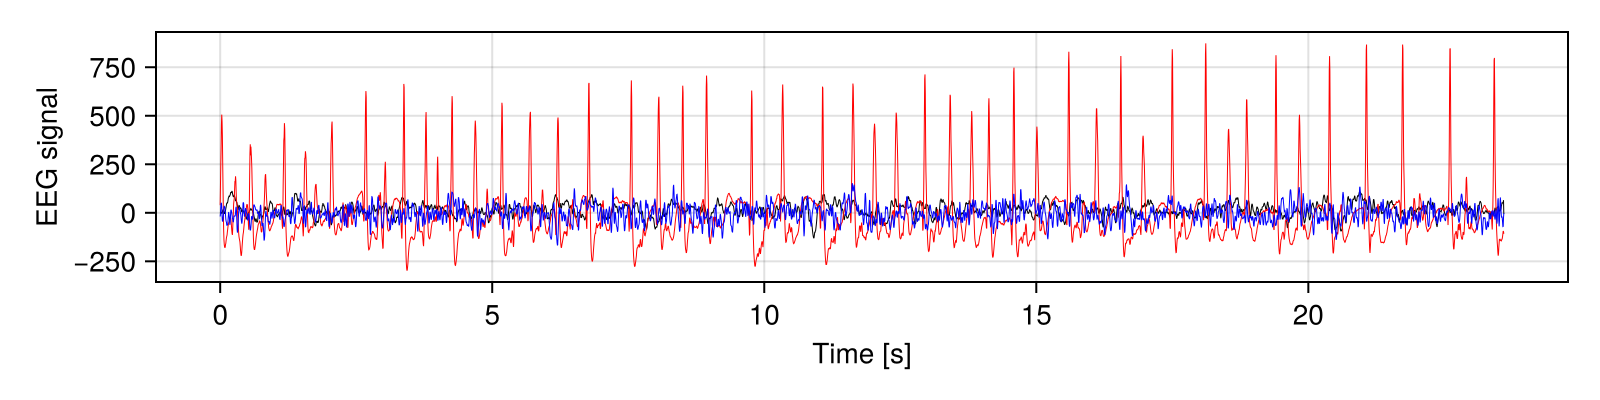

In [12]:
using DelimitedFiles
function eeg_data(path, folder, dataset)
    file = path*folder*"/"*dataset*".txt"
    eeg_trace = readdlm(file)[:,1]
    dt = 1/173.61
    eeg_time = 0:dt:(length(eeg_trace)-1)*dt

    return eeg_time, eeg_trace
end

# load data from textfile into structured array
time = Dict()
eeg = Dict()
for (label,dataset) in datasets
    time[label], eeg[label] = eeg_data(path, folder[dataset], dataset)
end
# dataset = datasets["example"]
# example_t, example_eeg = eeg_data(path, folder[dataset], dataset)
# dataset = datasets["control"]
# control_t, control_eeg = eeg_data(path, folder[dataset], dataset)
# dataset = datasets["seizure"]
# seizure_t, seizure_eeg = eeg_data(path, folder[dataset], dataset)

fig = Figure(size = (800, 200))
ax = Axis(fig[1, 1]; xlabel = "Time [s]", ylabel = "EEG signal")
lines!(time["control"], eeg["control"], color = :black, linewidth = 0.5)
lines!(time["seizure"], eeg["seizure"], color = :red, linewidth = 0.5)
lines!(time["example"], eeg["example"], color = :blue, linewidth = 0.5)
fig

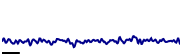

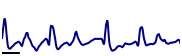

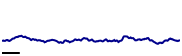

In [22]:
dt = 0.2 # s
ts = 0.0 .+ [0,dt]

inch = 96
mm = 2.83465 # pt
width = 32*mm
height = 10*mm

# get the min and max of the EEG signal across all datasets
ymin, ymax = (minimum([minimum(eeg[label]) for (label,_) in datasets]), maximum([maximum(eeg[label]) for (label,_) in datasets]))

for (label,_) in datasets
    fig = Figure(size=(width, height), fontsize=10, figure_padding=1, backgroundcolor=:transparent)
    ax = Axis(fig[1, 1]; xgridvisible=false, ygridvisible=false, backgroundcolor=:transparent)
    hidedecorations!(ax)
    hidespines!(ax)
    lines!(time[label], eeg[label], color = color=colorant"darkblue", linewidth = 1)
    xlims!(ax, (0, 2))
    ylims!(ax, (ymin, ymax))
        
    # scale bar as black line for duration of 200ms below the signal
    lines!(ax, [0.0, 0.2], [ymin, ymin], color = :black, linewidth = 2)

    # save as pdf with transparent background
    save(path_figures*"data_eeg_"*label*".pdf", fig, pt_per_unit = 1)
    display(fig)
end